In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from sklearn.feature_selection import mutual_info_regression
data = pd.read_csv('../../data/final_baseline_data.csv')

their_prediction = data['price day ahead']

data = data.drop(['generation fossil coal-derived gas', 'generation fossil oil shale', 
    'generation fossil peat', 'generation geothermal', 'generation marine', 
    'generation wind offshore', 'forecast solar day ahead', 'forecast wind onshore day ahead',
    'total load forecast', 'price day ahead'], axis = 1)

In [2]:
# select features for PREDICTING PRICE
feat_cols = ['temp', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_main_clear', 'weather_main_clouds', 'weather_main_drizzle',
       'weather_main_fog', 'weather_main_mist', 'weather_main_rain',
       'weather_main_thunderstorm', 'time_of_day_day', 'time_of_day_morning',
       'time_of_day_night', 'season_fall', 'season_spring', 'season_summer',
       'season_winter']

feat_cols_more = feat_cols + ['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste','generation wind onshore', 'total load actual']

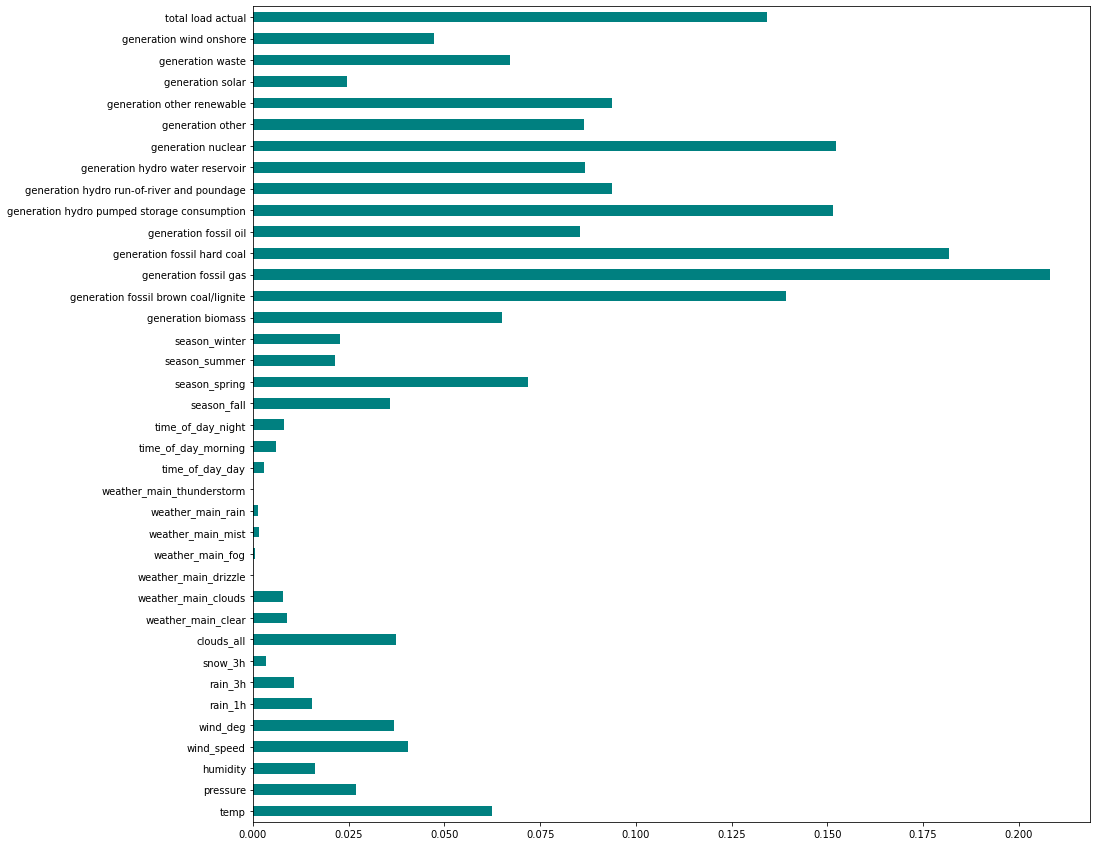

In [3]:
importances = mutual_info_regression(data[feat_cols_more], data['price actual'])
feat_importances = pd.Series(importances, feat_cols_more)
plt.figure(figsize=(15,15))
feat_importances.plot(kind='barh', color='teal')
plt.show()

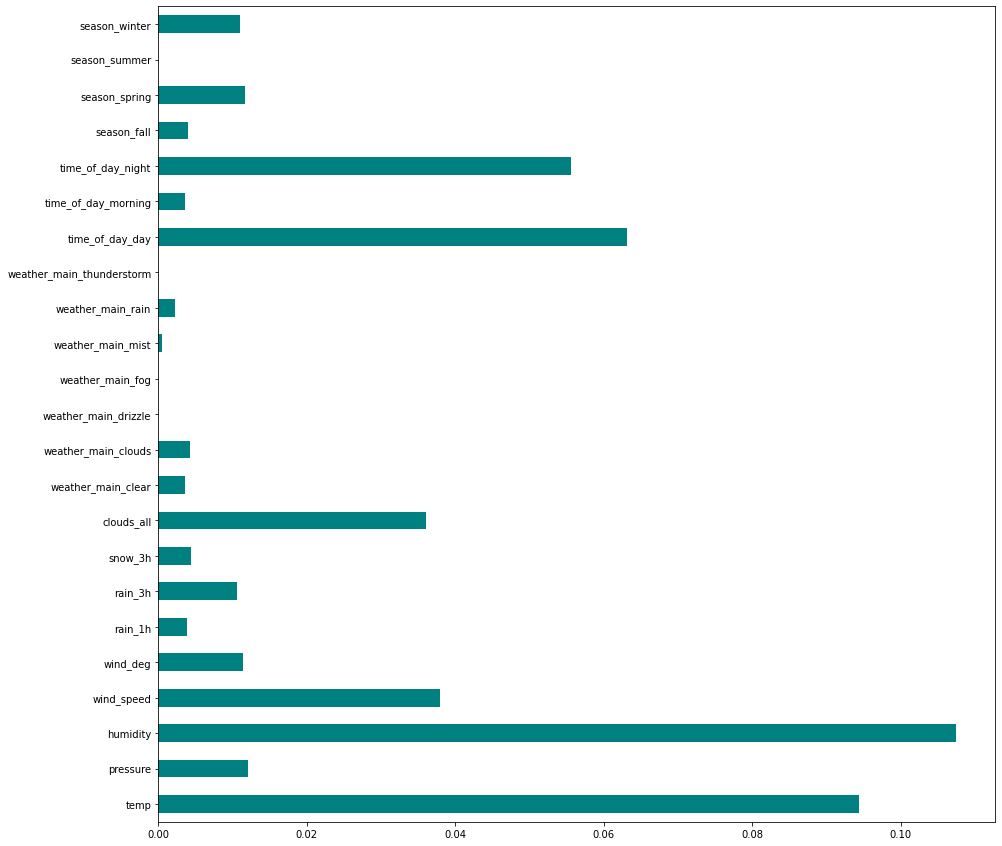

In [4]:
importances = mutual_info_regression(data[feat_cols], data['total load actual'])
feat_importances = pd.Series(importances, feat_cols)
plt.figure(figsize=(15,15))
feat_importances.plot(kind='barh', color='teal')
plt.show()

In [3]:
y = data['price actual']
x = data['total load actual']

## Polynomial Regression

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import operator
from sklearn.model_selection import train_test_split

white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Density')

def poly(x, y, degree):
    p = PolynomialFeatures(degree = degree)

    #get testing and training sets
    x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = 0.2)

    #transform testing and training dataset to p sized array
    x_poly_test = p.fit_transform(x_test.values.reshape(-1, 1))
    x_poly_train = p.fit_transform(x_train.values.reshape(-1, 1))

    #create and fit model to dataset
    model = linear_model.LinearRegression()
    model.fit(x_poly_train, y_train)

    #predict models
    y_train_pred = model.predict(x_poly_train)
    y_test_pred = model.predict(x_poly_test)

    #MSEs
    print('Training Mean Squared Error ', mean_squared_error(y_train, y_train_pred))
    print('Testing Mean Squared Error ', mean_squared_error(y_test, y_test_pred))
    print('Training Root Mean Squared Error ', np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print('Testing Root Mean Squared Error ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
    print('R2 score :', r2_score(y_test, y_test_pred))

    #plotting training data versus predicted data
    fig = plt.figure()
    scatter_density(fig, x, y)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x_train, y_train_pred), key = sort_axis)
    x_poly_train, y_train_pred = zip(*sorted_zip)
    plt.plot(x_poly_train, y_train_pred, 'r')
    plt.xlabel('total load (MW)')
    plt.ylabel('predicted price (EUR/MWh')

    plt.savefig('polynomial_regression')
    plt.show()


    return model, x_train, x_test, y_train, y_test

Training Mean Squared Error  163.35218141925583
Testing Mean Squared Error  163.0831493563225
Training Root Mean Squared Error  12.78093038159804
Testing Root Mean Squared Error  12.770401299736923
R2 score : 0.1875581357818673


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


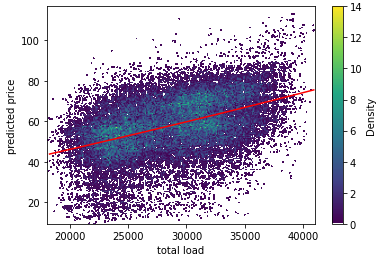

In [9]:
d2 = poly(x, y, 2)

Training Mean Squared Error  159.38117934376848
Testing Mean Squared Error  163.75678288999234
Training Root Mean Squared Error  12.624625909062354
Testing Root Mean Squared Error  12.796748918768092
R2 score : 0.18943040365256758


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


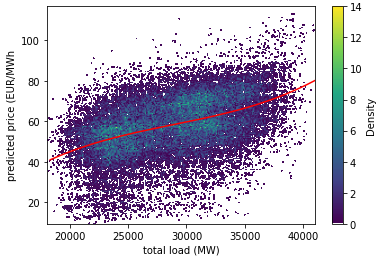

In [15]:
d3 = poly(x, y, 3)

In [16]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

def ridge(x, y, d):
    x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = 0.2)
    p = PolynomialFeatures(degree = d)
    x_poly_test = p.fit_transform(x_test.values.reshape(-1, 1))
    x_poly_train = p.fit_transform(x_train.values.reshape(-1, 1))
    steps = [('poly', p), ('model', Ridge(alpha = 10, fit_intercept = True))]
    ridge_pipe = Pipeline(steps)
    ridge_pipe.fit(x_poly_train, y_train)
    y_train_pred = ridge_pipe.predict(x_poly_train)
    y_test_pred = ridge_pipe.predict(x_poly_test)

    print('Training score: ', ridge_pipe.score(x_poly_train, y_train))
    print('Testing score: ', ridge_pipe.score(x_poly_test, y_test))

    fig = plt.figure()
    scatter_density(fig, x, y)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x_train, y_train_pred), key = sort_axis)
    x_poly_train, y_train_pred = zip(*sorted_zip)
    plt.plot(x_poly_train, y_train_pred, 'r')
    plt.show()

    

Training score:  0.19388378503867365
Testing score:  0.18875779906631684


c:\Users\chlw2\AppData\Local\Programs\Python\Python310\lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\chlw2\AppData\Local\Programs\Python\Python310\lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


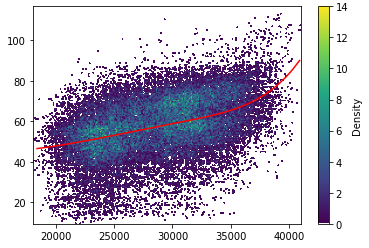

In [36]:
ridge(x, y, 3)

In [13]:
import xgboost
from sklearn.model_selection import train_test_split

#note: xgboost doesn't require scaling: https://medium.com/codex/feature-scaling-in-machine-learning-e86b360d1c31#:~:text=There%20are%20some%20algorithms%20like,data%20into%20training%20and%20testing.
from sklearn.preprocessing import MinMaxScaler
y = data['price actual']
#x = data['total load actual']
data = data.drop(['time', 'price actual'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.2)

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.2)
cv = KFold(n_splits = 5, random_state = 1, shuffle = True)

xgb = xgboost.XGBRegressor()

#param_grd = dict(n_estimators = [1000, 2000, 3000], max_depth = [1, 5, 10], eta = [0.3, 0.1, 0.01], subsample = [0.1, 0.5, 0.8], colsample_bytree = [0.1, 0.5, 1])
param_grd = dict(n_estimators = [100, 200, 300], max_depth = [1, 5, 10])

grid = GridSearchCV(estimator = xgb, param_grid = param_grd, n_jobs = -1, cv = cv)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=...
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    m

In [11]:
from sklearn.metrics import r2_score
grid.best_params_, grid.best_score_, r2_score(y_test, grid.predict(x_test))

({'max_depth': 10, 'n_estimators': 300}, 0.887332202134164, 0.9009571840980601)

In [12]:
xgb = xgboost.XGBRegressor()

#param_grd = dict(n_estimators = [1000, 2000, 3000], max_depth = [1, 5, 10], eta = [0.3, 0.1, 0.01], subsample = [0.1, 0.5, 0.8], colsample_bytree = [0.1, 0.5, 1])
param_grd = dict(n_estimators = [1000, 2000, 3000], max_depth = [10, 15, 20])

grid = GridSearchCV(estimator = xgb, param_grid = param_grd, n_jobs = -1, cv = cv)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=...
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    m

In [13]:
grid.best_params_, grid.best_score_, r2_score(y_test, grid.predict(x_test))

({'max_depth': 10, 'n_estimators': 1000},
 0.8874656752199825,
 0.9012359614831361)

In [22]:
xgb = xgboost.XGBRegressor()

#param_grd = dict(n_estimators = [1000, 2000, 3000], max_depth = [1, 5, 10], eta = [0.3, 0.1, 0.01], subsample = [0.1, 0.5, 0.8], colsample_bytree = [0.1, 0.5, 1])
param_grd = dict(n_estimators = [800], max_depth = [6, 7, 8, 9])

grid = GridSearchCV(estimator = xgb, param_grid = param_grd, n_jobs = -1, cv = cv)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=...
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    m

In [23]:
grid.best_params_, grid.best_score_, r2_score(y_test, grid.predict(x_test))

({'max_depth': 8, 'n_estimators': 800}, 0.8955807400786189, 0.903305682449346)

In [30]:
xgb = xgboost.XGBRegressor()

#param_grd = dict(n_estimators = [1000, 2000, 3000], max_depth = [1, 5, 10], eta = [0.3, 0.1, 0.01], subsample = [0.1, 0.5, 0.8], colsample_bytree = [0.1, 0.5, 1])
param_grd = dict(n_estimators = [800], max_depth = [8], eta = [0.07, 0.06, 0.05, 0.04], subsample = [0.6])

grid = GridSearchCV(estimator = xgb, param_grid = param_grd, n_jobs = -1, cv = cv)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                          

In [31]:
grid.best_params_, grid.best_score_, r2_score(y_test, grid.predict(x_test))

({'eta': 0.06, 'max_depth': 8, 'n_estimators': 800, 'subsample': 0.6},
 0.9212207289968888,
 0.9283787517481851)

In [32]:
xgb = xgboost.XGBRegressor()

#param_grd = dict(n_estimators = [1000, 2000, 3000], max_depth = [1, 5, 10], eta = [0.3, 0.1, 0.01], subsample = [0.1, 0.5, 0.8], colsample_bytree = [0.1, 0.5, 1])
param_grd = dict(n_estimators = [800], max_depth = [8], eta = [0.06], subsample = [0.6], colsample_bytree = [.1, .5, .8, 1])

grid = GridSearchCV(estimator = xgb, param_grid = param_grd, n_jobs = -1, cv = cv)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                          

In [12]:
from sklearn.model_selection import cross_val_score
grid.best_params_, grid.best_score_, r2_score(y_test, grid.predict(x_test)), cross_val_score(grid)

TypeError: cross_val_score() missing 1 required positional argument: 'X'

In [15]:
data.keys()

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_main_clear', 'weather_main_clouds', 'weather_main_drizzle',
       'weather_main_fog', 'weather_main_mist', 'weather_main_rain',
       'weather_main_thunderstorm', 'time_of_day_day', 'time_of_day_morning',
       'time_of_day_night', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [14]:
from sklearn.model_selection import cross_val_score
xgb = xgboost.XGBRegressor(n_estimators = 800, max_depth = 8, eta = 0.06, subsample = 0.6, colsample_bytree = 1, random_state = 42)

xgb.fit(x_train, y_train)
cross_val_score(xgb, x_test, y_test, cv = 5)

array([0.82333086, 0.81981723, 0.81893219, 0.83098843, 0.81489731])

In [7]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

for i in data:
    if 'generation' in i:
        data = data.drop([i], axis = 1)

data.keys()

load = data['total load actual']
loadx = data.drop(['total load actual', 'price actual', 'time'], axis = 1)

Index(['time', 'total load actual', 'price actual', 'temp', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'rain_3h', 'snow_3h', 'clouds_all', 'weather_main_clear',
       'weather_main_clouds', 'weather_main_drizzle', 'weather_main_fog',
       'weather_main_mist', 'weather_main_rain', 'weather_main_thunderstorm',
       'time_of_day_day', 'time_of_day_morning', 'time_of_day_night',
       'season_fall', 'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [11]:
x_train, x_test, y_train, y_test = train_test_split(loadx, load, test_size = 0.2)

cv = KFold(n_splits = 5, random_state = 1, shuffle = True)

xgb = xgboost.XGBRegressor()

#param_grd = dict(n_estimators = [1000, 2000, 3000], max_depth = [1, 5, 10], eta = [0.3, 0.1, 0.01], subsample = [0.1, 0.5, 0.8], colsample_bytree = [0.1, 0.5, 1])
param_grd = dict(n_estimators = [100, 200, 300], max_depth = [1, 5, 10])

grid = GridSearchCV(estimator = xgb, param_grid = param_grd, n_jobs = -1, cv = cv)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=...
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    m

In [13]:
grid.best_params_, grid.best_score_, r2_score(y_test, grid.predict(x_test))

({'max_depth': 10, 'n_estimators': 100},
 0.4422748118792632,
 0.46477397140674415)

In [15]:
grid.best_params_, grid.best_score_, r2_score(y_test, grid.predict(x_test))

({'eta': 0.1, 'max_depth': 9, 'n_estimators': 100},
 0.4624735310637207,
 0.4764231160834519)

In [18]:
param_grd = dict(n_estimators = [100], max_depth = [9], eta = [.2, .1, .09, .08, .07, .06], subsample = [0.1, 0.5, 0.8])

grid = GridSearchCV(estimator = xgb, param_grid = param_grd, n_jobs = -1, cv = cv)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                          

In [19]:
grid.best_params_, grid.best_score_, r2_score(y_test, grid.predict(x_test))

({'eta': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8},
 0.4667871584287199,
 0.4756594308376956)

In [20]:
param_grd = dict(n_estimators = [100], max_depth = [9], eta = [.1], subsample = [.6, .7, .8, .9], colsample_bytree = [0.1, .9, .8, 0.5, 1])

grid = GridSearchCV(estimator = xgb, param_grid = param_grd, n_jobs = -1, cv = cv)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                  

In [21]:
grid.best_params_, grid.best_score_, r2_score(y_test, grid.predict(x_test))

({'colsample_bytree': 1,
  'eta': 0.1,
  'max_depth': 9,
  'n_estimators': 100,
  'subsample': 0.9},
 0.4672291310035607,
 0.47269530670034454)